# Analysis for Experiment 2

In [11]:
rm(list= ls())

In [12]:
library(dplyr)
library(lme4)
library(lmerTest)
library(BayesFactor)
library(ggplot2)
library(stringr)

In [13]:
data.folder <- 'Experiment 2. Illusory Triangle and Common Region'
results <- read.csv(file.path(data.folder, 'Experiment2_Main.csv'), sep = ';')

## Analysis of disappearance duration: at least one target is invisible

In [14]:
subjective.states <- read.csv(file.path(data.folder, 'Experiment2_DisappearanceDuration.csv'), sep=';') #Experiment 1 - state duration.csv')

subjective.states <- subjective.states %>%
    # excluding training blocks
    filter(BlockDuration>30) %>% 

    # labelling individual condition for plotting
    mutate(Condition= sprintf('%s%d', c('M', 'A')[Aligned+1], MasksN)) %>% 
    mutate(Condition= factor(Condition, levels= c('M3', 'M1', 'A3', 'A1')))

subjective.states <- data.frame(subjective.states)
subjective.states$MasksN <- as.factor(subjective.states$MasksN)
subjective.states$Aligned <- as.factor(subjective.states$Aligned)

disappearance.time <- subjective.states %>%
    group_by(ID, Aligned, MasksN) %>%
    summarise(time.proportion= sum(Duration[TargetCount<3])/BlockDuration[1])
disappearance.time <- data.frame(disappearance.time)

lm.null <- lme4::lmer(time.proportion ~ 1 + (1|ID), data= disappearance.time, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.aligned <- update(lm.masks, .~. + Aligned)
lm.interaction <- update(lm.aligned, .~. + MasksN*Aligned)
anova(lm.null, lm.masks, lm.aligned, lm.interaction)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-160.7640,-153.3320,83.38201,-166.7640,NA,NA,NA
lm.masks,4,-160.4674,-150.5580,84.23370,-168.4674,1.70337672,1,0.19184697
lm.aligned,5,-161.9873,-149.6006,85.99365,-171.9873,3.51989653,1,0.06063623
lm.interaction,6,-160.0013,-145.1372,86.00064,-172.0013,0.01398031,1,0.90587880


Same analysis but using Bayesian ANOVA

In [15]:
# seeding random generator to ensure reproducable Bayesian MCMC results
set.seed(111122017)
duration.bayes <- sort(anovaBF(time.proportion ~ MasksN + Aligned + ID, data= disappearance.time, whichRandom = 'ID'), 
                       decreasing = TRUE)
duration.bayes

Bayes factor analysis
--------------
[1] Aligned + ID                           : 0.9749076 ±1.1%
[2] Aligned + MasksN + ID                  : 0.4557582 ±1.3%
[3] MasksN + ID                            : 0.4551943 ±1.02%
[4] Aligned + MasksN + Aligned:MasksN + ID : 0.1383031 ±3.88%

Against denominator:
  time.proportion ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: time.proportion ~ Condition + (1 | ID)
   Data: time.per.condition.lmer

REML criterion at convergence: -147.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.98656 -0.56242 -0.05411  0.44596  2.30185 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 0.01014  0.10069 
 Residual             0.00500  0.07071 
Number of obs: 88, groups:  ID, 22

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  0.23544    0.02623 35.81000   8.975 1.08e-10 ***
ConditionM1 -0.01813    0.02132 63.00000  -0.850   0.3983    
ConditionA3 -0.02627    0.02132 63.00000  -1.232   0.2225    
ConditionA1 -0.04788    0.02132 63.00000  -2.246   0.0282 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) CndtM1 CndtA3
ConditionM1 -0.406              


Estimate,Std.Error,df,t.value,p.value,R.sqr
0.23544242,0.02623189,35.81351,8.9754258,1.076690e-10,0.8320151
-0.01813182,0.02132065,63.00021,-0.8504348,3.983040e-01,0.1065348
-0.02626818,0.02132065,63.00021,-1.2320538,2.225076e-01,0.1533870
-0.04788333,0.02132065,63.00021,-2.2458670,2.822836e-02,0.2722630


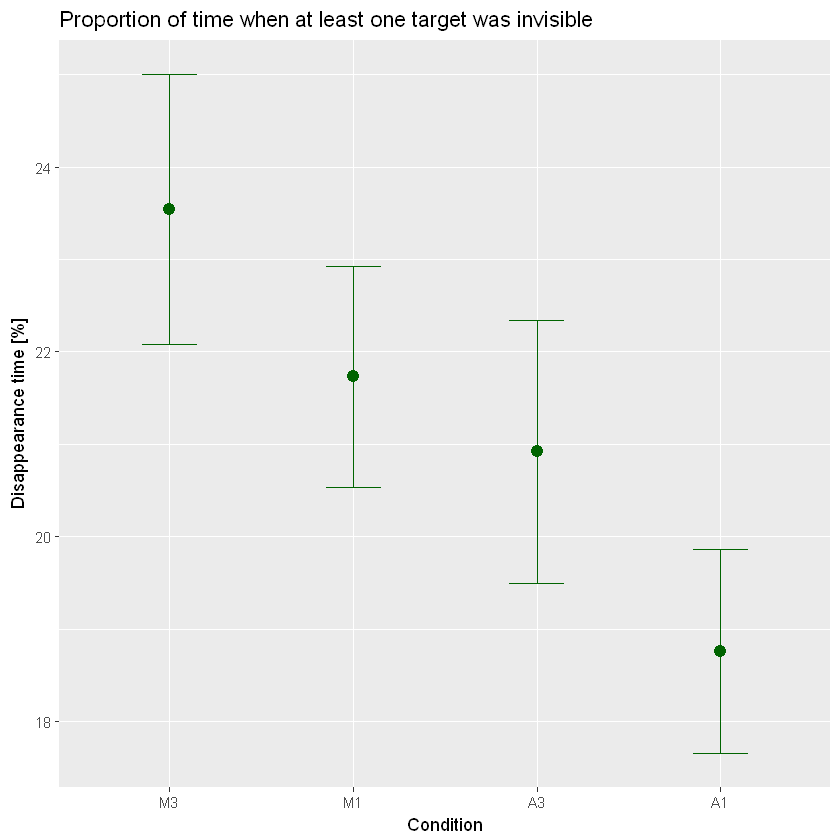

In [26]:
# averages per group
time.per.condition.plot <- subjective.states %>%

    # computing observer proportion per condition
    group_by(ID, Condition) %>%
    summarise(time.proportion= sum(Duration[TargetCount<3])/BlockDuration[1]) %>%

    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(time.proportion)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(time.proportion)) %>%
    mutate(time.adjusted= time.proportion - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(Condition) %>%
    summarise(time.avg= mean(time.adjusted*100),
              time.serr= sd(time.adjusted*100)/sqrt(n()))

# averages per condition x observer for linear mixed models
time.per.condition.lmer <- subjective.states %>%
    # computing observer proportion per condition
    group_by(ID, Condition) %>%
    summarise(time.proportion= sum(Duration[TargetCount<3])/BlockDuration[1])

# comparison to the baseline condition (M3)
duration.lmer <- summary(lmerTest::lmer(time.proportion ~ Condition + (1|ID), data= time.per.condition.lmer))
duration.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(duration.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# plot
time.plot <- ggplot(data= time.per.condition.plot, aes(x= Condition, y= time.avg, ymin= time.avg-time.serr, ymax= time.avg+time.serr))+
    geom_errorbar(color= 'darkgreen', width=0.3)+
    geom_point(color= 'darkgreen', size= 3) + 
    ylab('Disappearance time [%]') +
    ggtitle('Proportion of time when at least one target was invisible')
print(time.plot)


## Simultaneity of appearance and disappearance events 

Loading preprocessed data

In [17]:
results <- results %>%
    # excluding training blocks
    filter(Duration>30) %>% 

    # labelling individual condition for plotting
    mutate(Condition= sprintf('%s%d', c('M', 'A')[Aligned+1], MasksN)) %>% 
    mutate(Condition= factor(Condition, levels= c('M3', 'M1', 'A3', 'A1')))

results$MasksN <- as.factor(results$MasksN)
results$Aligned <- as.factor(results$Aligned)
results$Event <- as.factor(results$Event)

Using hierarchical linear mixed models to quantify effect of individual factors

In [18]:
sim.events <- results %>%
    group_by(ID, Aligned, MasksN, Event) %>%
    summarise(sim.proportion= sum(SimCount>1)/n())
sim.events <- data.frame(sim.events)

lm.null <- lme4::lmer(sim.proportion ~ 1 + (1|ID), data= sim.events, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.aligned <- update(lm.masks, .~. + Aligned)
lm.event <- update(lm.aligned, .~. + Event)
lm.mask.align <- update(lm.event, .~. + MasksN*Aligned)
lm.mask.event <- update(lm.mask.align, .~. + MasksN*Event)
lm.align.event <- update(lm.mask.event, .~. + Aligned*Event)
lm.full.interaction <- update(lm.align.event, .~. + MasksN*Aligned*Event)
anova(lm.null, lm.masks, lm.aligned, lm.event, lm.mask.align, lm.mask.event, lm.align.event, lm.full.interaction)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-105.1527,-95.64124,55.57635,-111.1527,NA,NA,NA
lm.masks,4,-121.6001,-108.91812,64.80003,-129.6001,18.447362788,1,1.746624e-05
lm.aligned,5,-119.6710,-103.81853,64.83548,-129.6710,0.070893611,1,7.900401e-01
lm.event,6,-117.6786,-98.65566,64.83928,-129.6786,0.007616687,1,9.304540e-01
lm.mask.align,7,-116.0219,-93.82855,65.01097,-130.0219,0.343374194,1,5.578880e-01
lm.mask.event,8,-115.0556,-89.69175,65.52781,-131.0556,1.033679430,1,3.092960e-01
lm.align.event,9,-113.1293,-84.59491,65.56463,-131.1293,0.073640086,1,7.861087e-01
lm.full.interaction,10,-111.1936,-79.48878,65.59681,-131.1936,0.064362355,1,7.997294e-01


Same analysis but using Bayesian ANOVA

In [29]:
set.seed(211122017)
sim.bayes <- sort(anovaBF(sim.proportion ~ MasksN+Aligned+Event+ID, data= data.frame(sim.events), whichRandom = 'ID'), decreasing = TRUE)
sim.bayes

Bayes factor analysis
--------------
[1] MasksN + ID                                                                                           : 897.1278    ±1.37%
[2] MasksN + Event + ID                                                                                   : 149.0479    ±3.05%
[3] Aligned + MasksN + ID                                                                                 : 148.2532    ±1.64%
[4] MasksN + Event + MasksN:Event + ID                                                                    : 49.90905    ±2.97%
[5] Aligned + MasksN + Aligned:MasksN + ID                                                                : 37.8673     ±2.26%
[6] Aligned + MasksN + Event + ID                                                                         : 23.38397    ±2%
[7] Aligned + MasksN + Event + MasksN:Event + ID                                                          : 7.68351     ±2.83%
[8] Aligned + MasksN + Aligned:MasksN + Event + ID                           

### Plotting the simultaneity results

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: sim.proportion ~ Condition + (1 | ID)
   Data: sim.per.condition.lmer

REML criterion at convergence: 731.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.22644 -0.48110  0.02745  0.43337  2.31596 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 372.5    19.30   
 Residual             172.8    13.15   
Number of obs: 88, groups:  ID, 22

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   48.458      4.979 35.010   9.733 1.71e-11 ***
ConditionM1   10.639      3.964 63.000   2.684  0.00928 ** 
ConditionA3    1.808      3.964 63.000   0.456  0.64991    
ConditionA1    9.961      3.964 63.000   2.513  0.01454 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) CndtM1 CndtA3
ConditionM1 -0.398              
ConditionA3 -

Estimate,Std.Error,df,t.value,p.value,R.sqr
48.457651,4.978734,35.00502,9.732926,1.710720e-11,0.85450589
10.639097,3.963984,62.99965,2.683940,9.284846e-03,0.32032764
1.807838,3.963984,62.99965,0.456066,6.499108e-01,0.05736445
9.961417,3.963984,62.99965,2.512981,1.454263e-02,0.30183976


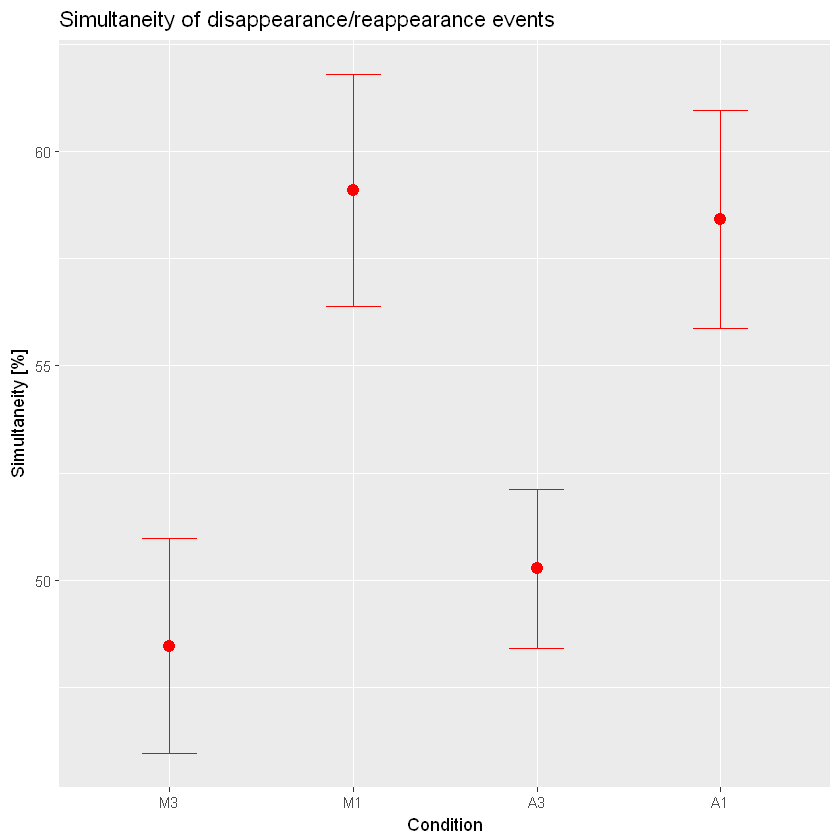

In [25]:
# averages per group
sim.per.condition.plot <- results %>%
    # computing observer proportion per condition
    group_by(ID, Condition) %>%
    summarise(sim.proportion= 100*sum(SimCount>1)/n()) %>%

    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(sim.proportion)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(sim.proportion)) %>%
    mutate(sim.adjusted= sim.proportion - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(Condition) %>%
    summarise(sim.avg= mean(sim.adjusted),
              sim.serr= sd(sim.adjusted)/sqrt(n()))

# averages per condition x observer for linear mixed models
sim.per.condition.lmer <- results %>%
    # computing observer proportion per condition
    group_by(ID, Condition) %>%
    summarise(sim.proportion= 100*sum(SimCount>1)/n())

# comparison to the baseline condition (M3)
sim.lmer <- summary(lmerTest::lmer(sim.proportion ~ Condition + (1|ID), data= sim.per.condition.lmer))
sim.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(sim.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# plot
sim.plot <- ggplot(data= sim.per.condition.plot, aes(x= Condition, y= sim.avg, ymin= sim.avg-sim.serr, ymax= sim.avg+sim.serr))+
    geom_errorbar(color= 'red', width=0.3)+
    geom_point(color= 'red', size= 3) + 
    ylab('Simultaneity [%]') + 
    ggtitle('Simultaneity of disappearance/reappearance events')
print(sim.plot)

## Analysis of disappearance duration: average disappearance across all targets

Computing average disappearance time across all targets

In [21]:
disappearance.across.targets <- results %>%
    # proportion of time a single target disappeared
    group_by(ID, Block, Aligned, MasksN, Target, Condition) %>%
    summarise(disapp.prop = sum(Time[Event==1]-Time[Event==0])/(1000 * Duration[1])) %>%

    # average across all of them
    group_by(ID, Aligned, MasksN, Condition) %>%
    summarise(disappearance.prop = mean(disapp.prop)*100)
disappearance.across.targets <- data.frame(disappearance.across.targets)

In [22]:
lm.null <- lme4::lmer(disappearance.prop ~ 1 + (1|ID), data= disappearance.across.targets, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
lm.aligned <- update(lm.masks, .~. + Aligned)
lm.interaction <- update(lm.aligned, .~. + MasksN*Aligned)
anova(lm.null, lm.masks, lm.aligned, lm.interaction)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,588.0100,595.4420,-291.0050,582.0100,NA,NA,NA
lm.masks,4,588.4672,598.3766,-290.2336,580.4672,1.54279793,1,0.21420182
lm.aligned,5,587.7127,600.0994,-288.8564,577.7127,2.75447776,1,0.09698248
lm.interaction,6,589.6488,604.5128,-288.8244,577.6488,0.06395807,1,0.80034601


In [23]:
set.seed(311122017)
duration.bayes <- sort(anovaBF(disappearance.prop ~ MasksN + Aligned + ID, data= disappearance.across.targets, whichRandom = 'ID'), 
                       decreasing = TRUE)
duration.bayes

Bayes factor analysis
--------------
[1] Aligned + ID                           : 0.6967405  ±1.19%
[2] MasksN + ID                            : 0.4387547  ±3.13%
[3] Aligned + MasksN + ID                  : 0.3100085  ±1.59%
[4] Aligned + MasksN + Aligned:MasksN + ID : 0.08999146 ±2.73%

Against denominator:
  disappearance.prop ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: disappearance.prop ~ Condition + (1 | ID)
   Data: disappearance.across.targets

REML criterion at convergence: 567.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.93950 -0.52979 -0.04127  0.45237  2.28904 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept) 48.54    6.967   
 Residual             25.36    5.036   
Number of obs: 88, groups:  ID, 22

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   14.655      1.833 36.610   7.996  1.5e-09 ***
ConditionM1   -1.074      1.518 63.000  -0.707   0.4822    
ConditionA3   -1.495      1.518 63.000  -0.984   0.3287    
ConditionA1   -3.099      1.518 63.000  -2.041   0.0454 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) CndtM1 CndtA3
ConditionM1 -0.414              
Con

Estimate,Std.Error,df,t.value,p.value,R.sqr
14.655429,1.832863,36.61277,7.9959209,1.504962e-09,0.79741209
-1.073554,1.518445,62.99993,-0.7070091,4.821678e-01,0.08872354
-1.494830,1.518445,62.99993,-0.9844478,3.286611e-01,0.12308572
-3.099104,1.518445,62.99993,-2.0409722,4.544836e-02,0.24903705


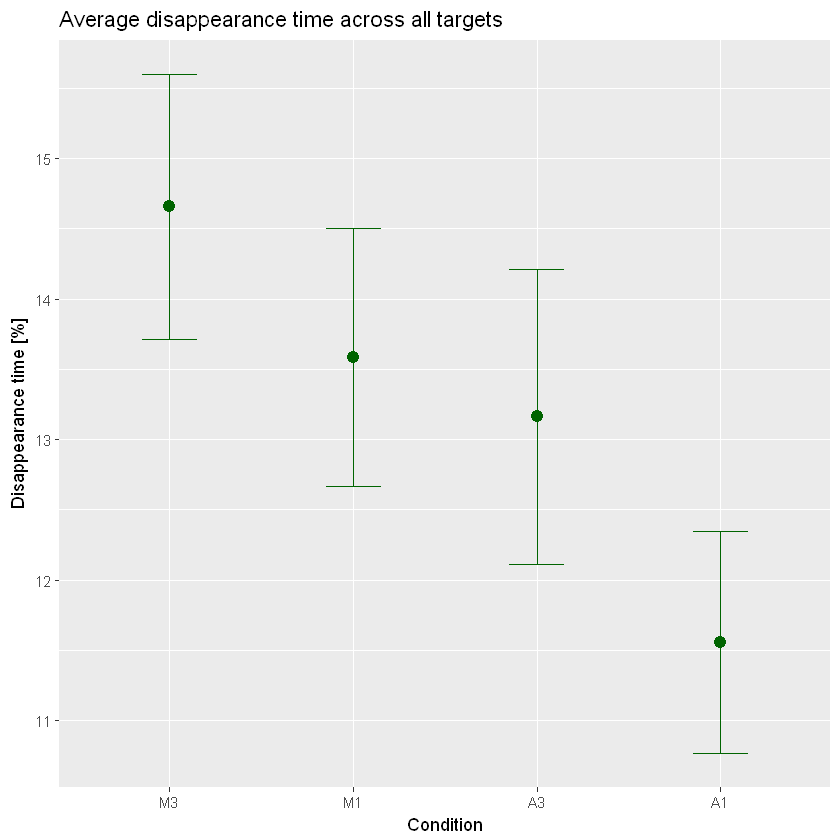

In [24]:
# averages per group
time.per.condition.plot <- disappearance.across.targets %>%
    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(disappearance.prop)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(disappearance.prop)) %>%
    mutate(time.adjusted= disappearance.prop - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(Condition) %>%
    summarise(time.avg= mean(time.adjusted),
              time.serr= sd(time.adjusted)/sqrt(n()))

# comparison to the baseline condition (M3)
duration.lmer <- summary(lmerTest::lmer(disappearance.prop ~ Condition + (1|ID), data= disappearance.across.targets))
duration.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(duration.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

# plot
time.plot <- ggplot(data= time.per.condition.plot, aes(x= Condition, y= time.avg, ymin= time.avg-time.serr, ymax= time.avg+time.serr))+
    geom_errorbar(color= 'darkgreen', width=0.3)+
    geom_point(color= 'darkgreen', size= 3) + 
    ylab('Disappearance time [%]') + 
    ggtitle('Average disappearance time across all targets')
print(time.plot)